In [12]:
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [17]:
DATA_PATH = Path('C:/Users/sande/OneDrive/Desktop/Deep Learning/Time Series Forecasting/egrid_all_plants_1996-2023.parquet')
TARGET_YEAR = 2023
TEST_SIZE = 0.2
RANDOM_STATE = 42
EPOCHS = 100
BATCH_SIZE = 64

MULTI-TASK LEARNING - PRODUCTION RUN
Loading 2023 data...
Loaded 12,613 plants

Training on 3,273 plants with complete data

TARGET CORRELATIONS
          log_co2   log_nox   log_so2
log_co2  1.000000  0.758413  0.453575
log_nox  0.758413  1.000000  0.624860
log_so2  0.453575  0.624860  1.000000
Train: 2,618 | Test: 655

[1/2] Training Multi-Task Learning Model...
  CO2 MAE: 1.6231
  NOx MAE: 0.9810
  SO2 MAE: 0.7571
  Average MAE: 1.1204

[2/2] Training Single-Task Baseline Models...
  Training CO2 model...
    MAE: 1.5641
  Training NOX model...
    MAE: 0.9090
  Training SO2 model...
    MAE: 0.7590
  Average MAE: 1.0774

Generating visualizations...


  Saved: 05_multi_task_results.png

Exported model to: mtl_emissions_model.h5
Exported scaler to: mtl_emissions_model_scaler.pkl

RESULTS SUMMARY
Task       Single-Task MAE      MTL MAE              Improvement
--------------------------------------------------------------------------------
CO₂        1.5641               1.6231               -3.8%
NOx        0.9090               0.9810               -7.9%
SO₂        0.7590               0.7571               +0.3%
--------------------------------------------------------------------------------
Average    1.0774               1.1204               -4.0%

✓ Complete!


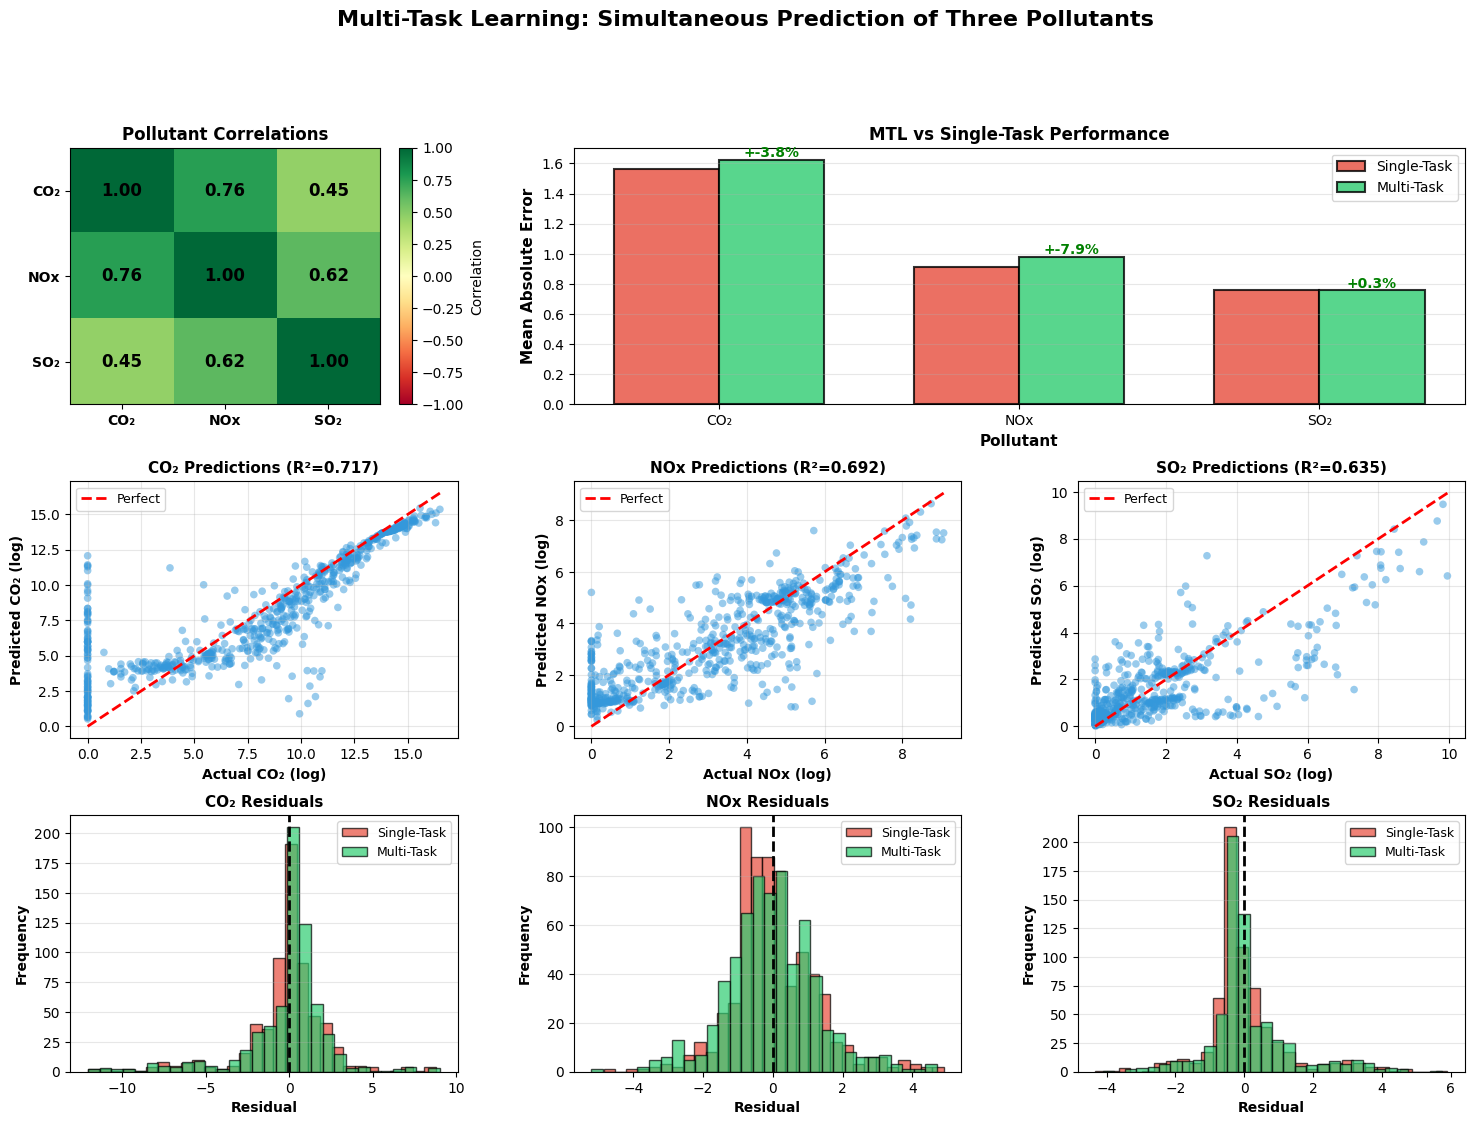

In [21]:
def load_and_prepare_data(year):
    """Load and prepare features for multi-task learning"""
    print(f"Loading {year} data...")
    plants = pd.read_parquet(DATA_PATH)
    df = plants[plants['data_year'] == year].copy()
    # print(df.columns.tolist())
    # Convert to numeric
    gen = pd.to_numeric(df['Plant annual net generation (MWh)'], errors='coerce')
    co2 = pd.to_numeric(df['Plant annual CO2 emissions (tons)'], errors='coerce')
    capacity = pd.to_numeric(df['Plant nameplate capacity (MW)'], errors='coerce')
    heat = pd.to_numeric(df['Plant total annual heat input (MMBtu)'], errors='coerce')
    
    # Find NOx and SO2 columns
    nox_col = [c for c in df.columns if 'NOx' in c and 'annual' in c and 'tons' in c][0]
    so2_col = [c for c in df.columns if 'SO2' in c and 'annual' in c and 'tons' in c][0]
    
    nox = pd.to_numeric(df[nox_col], errors='coerce')
    so2 = pd.to_numeric(df[so2_col], errors='coerce')
    
    # Create features
    df['capacity_mw'] = capacity
    df['generation_mwh'] = gen
    df['heat_input_mmbtu'] = heat
    df['capacity_factor'] = np.where(capacity > 0, gen / (capacity * 8760), np.nan)
    df['heat_rate'] = np.where(gen > 0, heat / gen, np.nan)
    
    # Targets (log-transformed for stability)
    df['log_co2'] = np.log1p(co2)
    df['log_nox'] = np.log1p(nox)
    df['log_so2'] = np.log1p(so2)
    
    print(f"Loaded {len(df):,} plants")
    return df

def build_mtl_model(input_dim, architecture='hard_sharing'):
    """
    Build multi-task learning model with hard parameter sharing
    """
    inputs = keras.Input(shape=(input_dim,), name='input_features')
    
    # Shared layers - learn common patterns
    shared = layers.Dense(128, activation='relu', name='shared_1')(inputs)
    shared = layers.BatchNormalization()(shared)
    shared = layers.Dropout(0.3)(shared)
    
    shared = layers.Dense(64, activation='relu', name='shared_2')(shared)
    shared = layers.BatchNormalization()(shared)
    shared = layers.Dropout(0.3)(shared)
    
    shared = layers.Dense(32, activation='relu', name='shared_3')(shared)
    shared = layers.BatchNormalization()(shared)
    
    # Task-specific heads
    co2_head = layers.Dense(16, activation='relu', name='co2_head')(shared)
    co2_output = layers.Dense(1, name='co2_output')(co2_head)
    
    nox_head = layers.Dense(16, activation='relu', name='nox_head')(shared)
    nox_output = layers.Dense(1, name='nox_output')(nox_head)
    
    so2_head = layers.Dense(16, activation='relu', name='so2_head')(shared)
    so2_output = layers.Dense(1, name='so2_output')(so2_head)
    
    model = keras.Model(
        inputs=inputs,
        outputs=[co2_output, nox_output, so2_output],
        name='mtl_emissions_predictor'
    )
    
    return model

def build_single_task_model(input_dim):
    """Build single-task baseline model"""
    model = keras.Sequential([
        keras.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_mtl_model(X_train, X_test, y_train, y_test):
    """Train multi-task learning model"""
    print("\n[1/2] Training Multi-Task Learning Model...")
    
    input_dim = X_train.shape[1]
    model = build_mtl_model(input_dim)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'co2_output': 'mse',
            'nox_output': 'mse',
            'so2_output': 'mse'
        },
        metrics={
            'co2_output': ['mae'],
            'nox_output': ['mae'],
            'so2_output': ['mae']
        }
    )
    
    # Train
    history = model.fit(
        X_train,
        {
            'co2_output': y_train['co2'],
            'nox_output': y_train['nox'],
            'so2_output': y_train['so2']
        },
        validation_split=0.2,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=0),
            keras.callbacks.ReduceLROnPlateau(patience=7, factor=0.5, verbose=0)
        ],
        verbose=0
    )
    
    # Predict
    y_pred_co2, y_pred_nox, y_pred_so2 = model.predict(X_test, verbose=0)
    
    # Evaluate
    mae_co2 = mean_absolute_error(y_test['co2'], y_pred_co2)
    mae_nox = mean_absolute_error(y_test['nox'], y_pred_nox)
    mae_so2 = mean_absolute_error(y_test['so2'], y_pred_so2)
    
    print(f"  CO2 MAE: {mae_co2:.4f}")
    print(f"  NOx MAE: {mae_nox:.4f}")
    print(f"  SO2 MAE: {mae_so2:.4f}")
    print(f"  Average MAE: {(mae_co2 + mae_nox + mae_so2)/3:.4f}")
    
    return {
        'model': model,
        'history': history,
        'predictions': {
            'co2': y_pred_co2.flatten(),
            'nox': y_pred_nox.flatten(),
            'so2': y_pred_so2.flatten()
        },
        'mae': {
            'co2': mae_co2,
            'nox': mae_nox,
            'so2': mae_so2
        }
    }

def train_single_task_models(X_train, X_test, y_train, y_test):
    """Train three separate single-task models"""
    print("\n[2/2] Training Single-Task Baseline Models...")
    
    input_dim = X_train.shape[1]
    results = {}
    
    for task in ['co2', 'nox', 'so2']:
        print(f"  Training {task.upper()} model...")
        
        model = build_single_task_model(input_dim)
        
        model.fit(
            X_train, y_train[task],
            validation_split=0.2,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=0)],
            verbose=0
        )
        
        y_pred = model.predict(X_test, verbose=0).flatten()
        mae = mean_absolute_error(y_test[task], y_pred)
        
        print(f"    MAE: {mae:.4f}")
        
        results[task] = {
            'model': model,
            'predictions': y_pred,
            'mae': mae
        }
    
    avg_mae = np.mean([results[task]['mae'] for task in ['co2', 'nox', 'so2']])
    print(f"  Average MAE: {avg_mae:.4f}")
    
    return results

def analyze_correlations(df, targets):
    """Analyze target correlations"""
    print("\nTARGET CORRELATIONS")
    print("=" * 80)
    
    corr_matrix = df[targets].corr()
    print(corr_matrix.to_string())
    
    return corr_matrix

def visualize_results(mtl_results, single_results, y_test, corr_matrix):
    """Create comprehensive visualization"""
    print("\nGenerating visualizations...")
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    tasks = ['co2', 'nox', 'so2']
    task_names = ['CO₂', 'NOx', 'SO₂']
    
    # Row 1: Correlation heatmap and performance comparison
    ax1 = fig.add_subplot(gs[0, 0])
    im = ax1.imshow(corr_matrix, cmap='RdYlGn', vmin=-1, vmax=1, aspect='auto')
    ax1.set_xticks(range(3))
    ax1.set_yticks(range(3))
    ax1.set_xticklabels(task_names, fontweight='bold')
    ax1.set_yticklabels(task_names, fontweight='bold')
    
    for i in range(3):
        for j in range(3):
            text = ax1.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", 
                           fontsize=12, fontweight='bold')
    
    ax1.set_title('Pollutant Correlations', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax1, label='Correlation')
    
    # Performance comparison
    ax2 = fig.add_subplot(gs[0, 1:])
    
    mtl_maes = [mtl_results['mae'][task] for task in tasks]
    single_maes = [single_results[task]['mae'] for task in tasks]
    improvements = [(single_maes[i] - mtl_maes[i]) / single_maes[i] * 100 
                   for i in range(len(tasks))]
    
    x = np.arange(len(task_names))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, single_maes, width, label='Single-Task', 
                   color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax2.bar(x + width/2, mtl_maes, width, label='Multi-Task', 
                   color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax2.set_xlabel('Pollutant', fontweight='bold', fontsize=11)
    ax2.set_ylabel('Mean Absolute Error', fontweight='bold', fontsize=11)
    ax2.set_title('MTL vs Single-Task Performance', fontweight='bold', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(task_names)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add improvement percentages
    for i, (bar, imp) in enumerate(zip(bars2, improvements)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'+{imp:.1f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='green')
    
    # Row 2: Prediction scatter plots
    for idx, (task, task_name) in enumerate(zip(tasks, task_names)):
        ax = fig.add_subplot(gs[1, idx])
        
        mtl_pred = mtl_results['predictions'][task]
        actual = y_test[task]
        
        ax.scatter(actual, mtl_pred, alpha=0.5, s=30, edgecolors='none', color='#3498db')
        
        # Perfect prediction line
        min_val = min(actual.min(), mtl_pred.min())
        max_val = max(actual.max(), mtl_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
        
        r2 = r2_score(actual, mtl_pred)
        
        ax.set_xlabel(f'Actual {task_name} (log)', fontweight='bold', fontsize=10)
        ax.set_ylabel(f'Predicted {task_name} (log)', fontweight='bold', fontsize=10)
        ax.set_title(f'{task_name} Predictions (R²={r2:.3f})', fontweight='bold', fontsize=11)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    # Row 3: Residual distributions
    for idx, (task, task_name) in enumerate(zip(tasks, task_names)):
        ax = fig.add_subplot(gs[2, idx])
        
        mtl_pred = mtl_results['predictions'][task]
        single_pred = single_results[task]['predictions']
        actual = y_test[task]
        
        mtl_residuals = actual - mtl_pred
        single_residuals = actual - single_pred
        
        ax.hist(single_residuals, bins=30, alpha=0.7, color='#e74c3c', 
               label='Single-Task', edgecolor='black')
        ax.hist(mtl_residuals, bins=30, alpha=0.7, color='#2ecc71', 
               label='Multi-Task', edgecolor='black')
        
        ax.axvline(0, color='black', linestyle='--', linewidth=2)
        ax.set_xlabel('Residual', fontweight='bold', fontsize=10)
        ax.set_ylabel('Frequency', fontweight='bold', fontsize=10)
        ax.set_title(f'{task_name} Residuals', fontweight='bold', fontsize=11)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'Multi-Task Learning: Simultaneous Prediction of Three Pollutants',
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.savefig('05_multi_task_results.png', dpi=300, bbox_inches='tight')
    print("  Saved: 05_multi_task_results.png")

def export_model(model, scaler, output_path='mtl_emissions_model.h5'):
    """Export trained model"""
    model.save(output_path)
    print(f"\nExported model to: {output_path}")
    
    # Save scaler separately
    import joblib
    scaler_path = output_path.replace('.h5', '_scaler.pkl')
    joblib.dump(scaler, scaler_path)
    print(f"Exported scaler to: {scaler_path}")

def main():
    """Main execution"""
    print("=" * 80)
    print("MULTI-TASK LEARNING - PRODUCTION RUN")
    print("=" * 80)
    
    # Load data
    df = load_and_prepare_data(TARGET_YEAR)
    
    # Prepare features and targets
    feature_cols = ['capacity_mw', 'generation_mwh', 'heat_input_mmbtu', 
                   'capacity_factor', 'heat_rate']
    target_cols = ['log_co2', 'log_nox', 'log_so2']
    
    # Filter complete cases
    data = df[feature_cols + target_cols].dropna()
    
    print(f"\nTraining on {len(data):,} plants with complete data")
    
    X = data[feature_cols]
    y = {
        'co2': data['log_co2'].values,
        'nox': data['log_nox'].values,
        'so2': data['log_so2'].values
    }
    
    # Analyze correlations
    corr_matrix = analyze_correlations(data, target_cols)
    
    # Train/test split
    X_train, X_test, y_co2_train, y_co2_test = train_test_split(
        X, y['co2'], test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    _, _, y_nox_train, y_nox_test = train_test_split(
        X, y['nox'], test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    _, _, y_so2_train, y_so2_test = train_test_split(
        X, y['so2'], test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    
    y_train = {'co2': y_co2_train, 'nox': y_nox_train, 'so2': y_so2_train}
    y_test = {'co2': y_co2_test, 'nox': y_nox_test, 'so2': y_so2_test}
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")
    
    # Train models
    mtl_results = train_mtl_model(X_train_scaled, X_test_scaled, y_train, y_test)
    single_results = train_single_task_models(X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Visualize
    visualize_results(mtl_results, single_results, y_test, corr_matrix)
    
    # Export
    export_model(mtl_results['model'], scaler)
    
    # Summary
    print("\n" + "=" * 80)
    print("RESULTS SUMMARY")
    print("=" * 80)
    print(f"{'Task':<10} {'Single-Task MAE':<20} {'MTL MAE':<20} {'Improvement'}")
    print("-" * 80)
    
    for task, name in [('co2', 'CO₂'), ('nox', 'NOx'), ('so2', 'SO₂')]:
        single_mae = single_results[task]['mae']
        mtl_mae = mtl_results['mae'][task]
        improvement = (single_mae - mtl_mae) / single_mae * 100
        
        print(f"{name:<10} {single_mae:<20.4f} {mtl_mae:<20.4f} {improvement:+.1f}%")
    
    # Average improvement
    avg_single = np.mean([single_results[t]['mae'] for t in ['co2', 'nox', 'so2']])
    avg_mtl = np.mean([mtl_results['mae'][t] for t in ['co2', 'nox', 'so2']])
    avg_improvement = (avg_single - avg_mtl) / avg_single * 100
    
    print("-" * 80)
    print(f"{'Average':<10} {avg_single:<20.4f} {avg_mtl:<20.4f} {avg_improvement:+.1f}%")
    
    print("\n" + "=" * 80)
    print("✓ Complete!")
    print("=" * 80)
    
    return {
        'mtl': mtl_results,
        'single_task': single_results,
        'scaler': scaler
    }

if __name__ == '__main__':
    results = main()